## VGG-Face


![](https://media5.datahacker.rs/2021/11/image-28.png)

O **VGG-Face** é um modelo de deep learning treinado especificamente para **reconhecimento facial**. Ele foi proposto pelo Visual Geometry Group (VGG) da Universidade de Oxford e é baseado na mesma arquitetura profunda da rede VGG-16, mas treinado com milhões de imagens de rostos humanos.


### Objetivo

Nosso objetivo ao usar o VGG-Face não é realizar classificação direta de identidades conhecidas, mas sim **extrair uma representação vetorial única (embedding)** para cada rosto.

Esses vetores capturam **características profundas do rosto**, como estrutura óssea, distância entre os olhos, formato do nariz, etc. Com esses embeddings, podemos:

- Comparar dois rostos e estimar se pertencem à mesma pessoa.
- Criar um banco de rostos conhecidos (galeria) e reconhecer novos rostos comparando com os embeddings salvos.
- Realizar agrupamentos e buscas por similaridade facial.


### O que o modelo retorna?

O modelo VGG-Face, ao ser configurado para retornar a **penúltima camada antes da classificação final**, entrega um vetor de características (embedding) com 2622 dimensões.

Cada rosto, portanto, é transformado em um vetor:

$$
\text{Rosto} \rightarrow \vec{v} \in \mathbb{R}^{2622}
$$

Esse vetor pode ser comparado com outro vetor de rosto usando **métricas de distância** como:

- **Distância Euclidiana**
- **Distância do Cosseno**


### Por que não usamos a camada `softmax`?

A última camada `softmax` da rede é usada apenas quando queremos classificar um rosto em um conjunto fixo de pessoas conhecidas (usadas no treinamento original). No nosso caso, queremos **generalizar** para rostos que o modelo nunca viu.

Por isso, usamos os **embeddings** como **descritores vetoriais**, e a etapa de reconhecimento é feita por similaridade entre esses vetores.




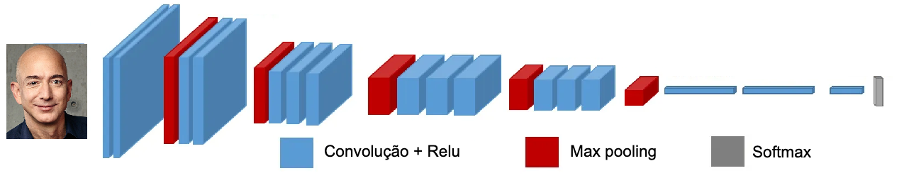

o download dos pesos da rede pode ser baixo em:

- vgg_face_weights.h5

- [https://github.com/serengil/deepface_models/releases/](https://github.com/serengil/deepface_models/releases/)
- [https://huggingface.co/RaphaelLiu/EvalCrafter-Models/blob/main/vgg_face_weights.h5](https://huggingface.co/RaphaelLiu/EvalCrafter-Models/blob/main/vgg_face_weights.h5)
- [https://github.com/yzhang559/vgg-face/blob/master/vggface.h5](https://github.com/yzhang559/vgg-face/blob/master/vggface.h5)



In [1]:
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Model
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Flatten, Dropout, Activation, Input
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Normaliza a entrada na escala de [-1, +1]
    return img

def load_vgg_face_model(weights_path='vgg_face_weights.h5'):
    input_layer = Input(shape=(224, 224, 3))
    x = ZeroPadding2D((1, 1))(input_layer)
    x = Convolution2D(64, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(128, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(256, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(256, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Convolution2D(4096, (7, 7), activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Convolution2D(4096, (1, 1), activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Convolution2D(2622, (1, 1))(x)
    x = Flatten()(x)   # minha camada de saída da rede, com as features extraídas
    out = Activation('softmax')(x)

    model = Model(inputs=input_layer, outputs=out)
    model.load_weights(weights_path)

    # Retorna o modelo sem a última camada softmax (extração de features)
    feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    return feature_model


# Carrega VGG-Face model
model = load_vgg_face_model('vgg-face/vgg_face_weights.h5')

# Gera representações das imagens
img1_representation = model.predict(preprocess_image('img20.png'))[0, :]
img2_representation = model.predict(preprocess_image('img21.png'))[0, :]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


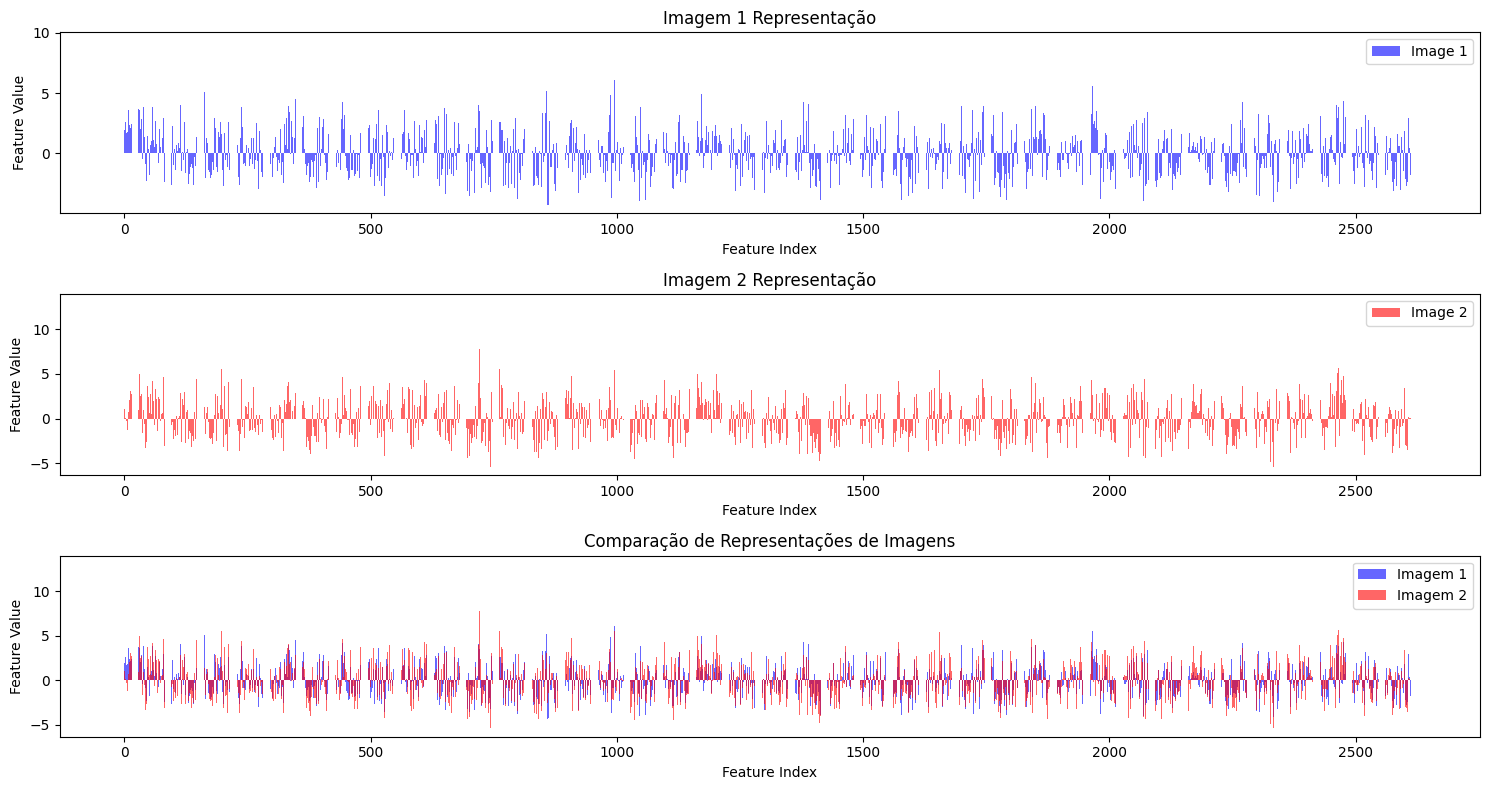

In [2]:
import matplotlib.pyplot as plt

def plot_representations(rep1, rep2, title1='Imagem 1 Representação', title2='Imagem 2 Representação'):
    fig, ax = plt.subplots(3, 1, figsize=(15, 8))
    
    ax[0].bar(range(len(rep1)), rep1, color='b', alpha=0.6, label='Image 1')
    ax[0].set_title(title1)
    ax[0].set_xlabel('Feature Index')
    ax[0].set_ylabel('Feature Value')
    ax[0].legend()
    
    ax[1].bar(range(len(rep2)), rep2, color='r', alpha=0.6, label='Image 2')
    ax[1].set_title(title2)
    ax[1].set_xlabel('Feature Index')
    ax[1].set_ylabel('Feature Value')
    ax[1].legend()
    
    # Plot sobreposição de características das imagens 1 e 2 para comparação visual direta 
    ax[2].bar(range(len(rep1)), rep1, color='b', alpha=0.6, label='Imagem 1')
    ax[2].bar(range(len(rep2)), rep2, color='r', alpha=0.6, label='Imagem 2')
    ax[2].set_title('Comparação de Representações de Imagens')
    ax[2].set_xlabel('Feature Index')
    ax[2].set_ylabel('Feature Value')
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()

# Exibir as representações das imagens
plot_representations(img1_representation, img2_representation)


## Similaridade e Distância em Reconhecimento de Imagens

Quando trabalhamos com **representações vetoriais** de imagens (por exemplo, embeddings gerados por uma rede neural como a VGG-Face), é essencial termos uma forma de **comparar** esses vetores. Isso nos permite responder perguntas como:

> *Essas duas imagens representam a mesma pessoa?*

Para isso, usamos **funções de distância** ou **funções de similaridade**, que medem o quão "próximos" ou "distantes" dois vetores estão no espaço.


## Cosine Distance (Distância do Cosseno)

A **distância do cosseno** mede o ângulo entre dois vetores. Ela **não leva em conta o módulo (comprimento)** dos vetores, apenas sua **direção**.

A fórmula da distância do cosseno é:

$$
\text{distância} = 1 - \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$

- O valor varia de **0** (vetores idênticos em direção) até **2** (vetores opostos).
- Em problemas de **reconhecimento facial**, essa medida é útil porque queremos saber se dois vetores apontam para a mesma direção, mesmo que tenham magnitudes diferentes.

#### Euclidean Distance (Distância Euclidiana)

A **distância euclidiana** é a tradicional distância entre dois pontos no espaço cartesiano:

$$
\text{distância} = \|A - B\|
$$

- Mede o comprimento da linha reta entre os dois vetores.
- É sensível à escala e magnitude dos vetores.
- Pode ser menos robusta quando os embeddings não estão normalizados.


## Aplicação prática

No contexto de **reconhecimento facial**, usamos essas distâncias para comparar uma **imagem capturada** com um **banco de rostos conhecidos**. Se a distância for pequena (ou a similaridade alta), assumimos que é a **mesma pessoa**.

A escolha da métrica e do **limiar (threshold)** é fundamental para a **precisão do sistema**.

- **Cosine distance** é preferida quando:
  - Os vetores estão normalizados (como no caso do `preprocess_input` do VGG-Face).
  - Queremos comparar **direções** no espaço vetorial (útil para comparar "estilo", "padrão", "identidade").

- **Euclidean distance** é preferida quando:
  - Os embeddings são **densos e bem calibrados**, e a **distância absoluta** tem significado direto.
  - Estamos comparando **pontos próximos em magnitude e direção**.



In [3]:
def find_cosine_distance(source_representation, test_representation):
    a = np.dot(source_representation, test_representation)
    b = np.linalg.norm(source_representation) * np.linalg.norm(test_representation)
    return 1 - (a / b)

def find_euclidean_distance(source_representation, test_representation):
    euclidean_distance = np.linalg.norm(source_representation - test_representation)
    return euclidean_distance

cosine_similarity = find_cosine_distance(img1_representation, img2_representation)
euclidean_distance = find_euclidean_distance(img1_representation, img2_representation)

print(cosine_similarity, euclidean_distance)

0.2897617816925049 79.59859


In [4]:
epsilon = 0.40  # similaridade coseno
# epsilon = 120  # distância euclidiana

def verify_face(img1, img2):
    img1_representation = model.predict(preprocess_image(img1))[0, :]
    img2_representation = model.predict(preprocess_image(img2))[0, :]
    
    cosine_similarity = find_cosine_distance(img1_representation, img2_representation)
    euclidean_distance = find_euclidean_distance(img1_representation, img2_representation)
    
    if cosine_similarity < epsilon:
        print("Verificado... são a mesma pessoa")
    else:
        print("Não verificado! Não são a mesma pessoa")
    
    return cosine_similarity, euclidean_distance

# Verificar as imagens
cosine_similarity, euclidean_distance = verify_face('img20.png', 'img21.png')
print(f"distância do cosseno: {cosine_similarity}")
print(f"distância euclidiana: {euclidean_distance}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Verificado... são a mesma pessoa
distância do cosseno: 0.2897617816925049
distância euclidiana: 79.59858703613281
